# **遥感图像分割**

一、项目背景介绍
=======
 遥感影像地块分割在城乡规划、防汛救灾等领域具有很高的实用价值，在工业界受到了广泛关注，对多来源、多场景的异构遥感影像数据进行充分挖掘，打造高效、实用的算法，提高遥感影像的分析提取能力。

二、数据集介绍
=======
本项目使用的数据集是[Aerial imagery dataset](https://aistudio.baidu.com/aistudio/datasetdetail/69911)，包括187000座建筑物含8188张512x512大小的建筑提取数据集

解压缩数据集
--------

In [1]:
! unzip -q /home/aistudio/data/data69911/BuildData.zip -d DataSet

安装paddleseg
--------

In [2]:
! pip install paddleseg

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


三、模型介绍
=======
关于UNet++，相比于原始的Unet网络，为了避免UNet中的纯跳跃连接在语义上的不相似特征的融合，UNet++通过引入嵌套的和密集的跳跃连接进一步加强了这些连接，目的是减少编码器和解码器之间的语义差距
![](https://ai-studio-static-online.cdn.bcebos.com/d338f5564c964dc8aebfcbad9c44de6ba642a106cf8146ebb65f25ccfa8c0eed)


四、模型训练
=======

生成训练集和测试集
--------

数据列表生成完成


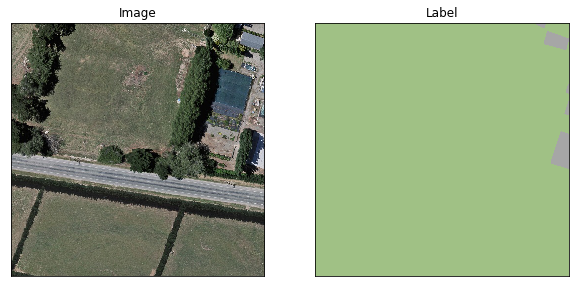

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

def create_list(data_path):
    image_path = os.path.join(data_path, 'image')
    label_path = os.path.join(data_path, 'label')
    data_names = os.listdir(image_path)
    random.shuffle(data_names)  # 打乱数据
    with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
        with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
            for idx, data_name in enumerate(data_names):
                img = os.path.join('image', data_name)
                lab = os.path.join('label', data_name.replace('jpg', 'png'))
                if idx % 9 == 0:  # 90%的作为训练集
                    vf.write(img + ' ' + lab + '\n')
                else:
                    tf.write(img + ' ' + lab + '\n')
    print('数据列表生成完成')

data_path = 'DataSet'
create_list(data_path)  # 生成数据列表

# 查看一组数据
vis_img = Image.open('DataSet/image/0026.jpg')
vis_lab = Image.open('DataSet/label/0026.png')
plt.figure(figsize=(10, 20))
plt.subplot(121);plt.imshow(vis_img);plt.xticks([]);plt.yticks([]);plt.title('Image')
plt.subplot(122);plt.imshow(vis_lab);plt.xticks([]);plt.yticks([]);plt.title('Label')
plt.show()

训练
--------

In [4]:
import paddle
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
from paddleseg.models.losses import BCELoss
from paddleseg.core import train

def train_model(base_lr=0.00001, iters=10000, batch_size=8, save_interval=1000, model_path=None):
    # 网络定义
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # 构建训练集
    train_transforms = [
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(),
        T.RandomScaleAspect(),
        T.RandomDistort(),
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    train_dataset = Dataset(
        transforms=train_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='train',
        train_path='DataSet/train_list.txt',
        separator=' ',
    )
    # 构建验证集
    val_transforms = [
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    val_dataset = Dataset(
        transforms=val_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='val',
        val_path='DataSet/val_list.txt',
        separator=' ',
    )
    # 参数设置
    lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=2000, last_epoch=0.5)
    optimizer = paddle.optimizer.Adam(lr, parameters=model.parameters())
    losses = {}
    losses['types'] = [BCELoss()]
    losses['coef'] = [1]
    # 训练
    train(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        optimizer=optimizer,
        save_dir='output',
        iters=iters,
        batch_size=batch_size,
        save_interval=save_interval,
        log_iters=10,
        num_workers=0,
        losses=losses,
        use_vdl=False)


In [ ]:
train_model(base_lr=0.001, iters=1000, batch_size=1)

W0220 19:13:59.847924   101 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0220 19:13:59.853647   101 device_context.cc:465] device: 0, cuDNN Version: 7.6.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


2022-02-20 19:14:04 [INFO]	[TRAIN] epoch: 1, iter: 10/1000, loss: 0.6285, lr: 0.001000, batch_cost: 0.1198, reader_cost: 0.01663, ips: 8.3497 samples/sec | ETA 00:01:58
2022-02-20 19:14:05 [INFO]	[TRAIN] epoch: 1, iter: 20/1000, loss: 0.4789, lr: 0.001000, batch_cost: 0.0953, reader_cost: 0.00010, ips: 10.4944 samples/sec | ETA 00:01:33
2022-02-20 19:14:06 [INFO]	[TRAIN] epoch: 1, iter: 30/1000, loss: 0.4787, lr: 0.000999, batch_cost: 0.0966, reader_cost: 0.00150, ips: 10.3491 samples/sec | ETA 00:01:33
2022-02-20 19:14:07 [INFO]	[TRAIN] epoch: 1, iter: 40/1000, loss: 0.4455, lr: 0.000999, batch_cost: 0.0962, reader_cost: 0.00011, ips: 10.3936 samples/sec | ETA 00:01:32
2022-02-20 19:14:08 [INFO]	[TRAIN] epoch: 1, iter: 50/1000, loss: 0.4115, lr: 0.000998, batch_cost: 0.0954, reader_cost: 0.00010, ips: 10.4781 samples/sec | ETA 00:01:30
2022-02-20 19:14:09 [INFO]	[TRAIN] epoch: 1, iter: 60/1000, loss: 0.4047, lr: 0.000998, batch_cost: 0.0954, reader_cost: 0.00011, ips: 10.4815 samples/

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0225 - reader cost: 1.0381e-


2022-02-20 19:16:01 [INFO]	[EVAL] #Images: 910 mIoU: 0.6877 Acc: 0.8783 Kappa: 0.6085 Dice: 0.8024
2022-02-20 19:16:01 [INFO]	[EVAL] Class IoU: 
[0.5151 0.8603]
2022-02-20 19:16:01 [INFO]	[EVAL] Class Acc: 
[0.5666 0.9704]
2022-02-20 19:16:01 [INFO]	[EVAL] The model with the best validation mIoU (0.6877) was saved at iter 1000.
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
<class 'paddle.nn.layer.conv.Conv2DTranspose'>'s flops has been counted
Total Flops: 135775911936     Total Params: 9057000


机器学习
--------

In [8]:
train_model(base_lr=0.00001, iters=10000, batch_size=1)

2022-02-20 19:17:43 [INFO]	[TRAIN] epoch: 1, iter: 10/10000, loss: 0.6884, lr: 0.000010, batch_cost: 0.1148, reader_cost: 0.00610, ips: 8.7124 samples/sec | ETA 00:19:06
2022-02-20 19:17:44 [INFO]	[TRAIN] epoch: 1, iter: 20/10000, loss: 0.6852, lr: 0.000010, batch_cost: 0.1018, reader_cost: 0.00016, ips: 9.8199 samples/sec | ETA 00:16:56
2022-02-20 19:17:45 [INFO]	[TRAIN] epoch: 1, iter: 30/10000, loss: 0.6789, lr: 0.000010, batch_cost: 0.0986, reader_cost: 0.00068, ips: 10.1411 samples/sec | ETA 00:16:23
2022-02-20 19:17:46 [INFO]	[TRAIN] epoch: 1, iter: 40/10000, loss: 0.6713, lr: 0.000010, batch_cost: 0.0982, reader_cost: 0.00046, ips: 10.1879 samples/sec | ETA 00:16:17
2022-02-20 19:17:47 [INFO]	[TRAIN] epoch: 1, iter: 50/10000, loss: 0.6752, lr: 0.000010, batch_cost: 0.0961, reader_cost: 0.00016, ips: 10.4106 samples/sec | ETA 00:15:55
2022-02-20 19:17:48 [INFO]	[TRAIN] epoch: 1, iter: 60/10000, loss: 0.6660, lr: 0.000010, batch_cost: 0.0961, reader_cost: 0.00014, ips: 10.4012 sam

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0227 - reader cost: 1.0768e-


2022-02-20 19:19:40 [INFO]	[EVAL] #Images: 910 mIoU: 0.6474 Acc: 0.8545 Kappa: 0.5463 Dice: 0.7702
2022-02-20 19:19:40 [INFO]	[EVAL] Class IoU: 
[0.461  0.8338]
2022-02-20 19:19:40 [INFO]	[EVAL] Class Acc: 
[0.5134 0.9636]
2022-02-20 19:19:41 [INFO]	[EVAL] The model with the best validation mIoU (0.6474) was saved at iter 1000.
2022-02-20 19:19:42 [INFO]	[TRAIN] epoch: 1, iter: 1010/10000, loss: 0.4590, lr: 0.000005, batch_cost: 0.0967, reader_cost: 0.00060, ips: 10.3411 samples/sec | ETA 00:14:29
2022-02-20 19:19:43 [INFO]	[TRAIN] epoch: 1, iter: 1020/10000, loss: 0.4836, lr: 0.000005, batch_cost: 0.0966, reader_cost: 0.00064, ips: 10.3542 samples/sec | ETA 00:14:27
2022-02-20 19:19:44 [INFO]	[TRAIN] epoch: 1, iter: 1030/10000, loss: 0.4923, lr: 0.000005, batch_cost: 0.0960, reader_cost: 0.00049, ips: 10.4218 samples/sec | ETA 00:14:20
2022-02-20 19:19:45 [INFO]	[TRAIN] epoch: 1, iter: 1040/10000, loss: 0.4547, lr: 0.000005, batch_cost: 0.0955, reader_cost: 0.00011, ips: 10.4692 sampl

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0234 - reader cost: 1.0742e-0


2022-02-20 19:21:40 [INFO]	[EVAL] #Images: 910 mIoU: 0.5174 Acc: 0.7358 Kappa: 0.3712 Dice: 0.6638
2022-02-20 19:21:40 [INFO]	[EVAL] Class IoU: 
[0.3407 0.694 ]
2022-02-20 19:21:40 [INFO]	[EVAL] Class Acc: 
[0.3544 0.9748]
2022-02-20 19:21:40 [INFO]	[EVAL] The model with the best validation mIoU (0.6474) was saved at iter 1000.
2022-02-20 19:21:41 [INFO]	[TRAIN] epoch: 1, iter: 2010/10000, loss: 0.4616, lr: 0.000000, batch_cost: 0.0955, reader_cost: 0.00011, ips: 10.4732 samples/sec | ETA 00:12:42
2022-02-20 19:21:42 [INFO]	[TRAIN] epoch: 1, iter: 2020/10000, loss: 0.4538, lr: 0.000000, batch_cost: 0.0974, reader_cost: 0.00114, ips: 10.2657 samples/sec | ETA 00:12:57
2022-02-20 19:21:43 [INFO]	[TRAIN] epoch: 1, iter: 2030/10000, loss: 0.4382, lr: 0.000000, batch_cost: 0.0965, reader_cost: 0.00058, ips: 10.3632 samples/sec | ETA 00:12:49
2022-02-20 19:21:44 [INFO]	[TRAIN] epoch: 1, iter: 2040/10000, loss: 0.4485, lr: 0.000000, batch_cost: 0.0953, reader_cost: 0.00010, ips: 10.4898 sampl

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0230 - reader cost: 1.1069e-


2022-02-20 19:23:38 [INFO]	[EVAL] #Images: 910 mIoU: 0.6250 Acc: 0.8349 Kappa: 0.5164 Dice: 0.7530
2022-02-20 19:23:38 [INFO]	[EVAL] Class IoU: 
[0.4396 0.8103]
2022-02-20 19:23:38 [INFO]	[EVAL] Class Acc: 
[0.4759 0.9691]
2022-02-20 19:23:39 [INFO]	[EVAL] The model with the best validation mIoU (0.6474) was saved at iter 1000.
2022-02-20 19:23:40 [INFO]	[TRAIN] epoch: 1, iter: 3010/10000, loss: 0.4454, lr: 0.000005, batch_cost: 0.0990, reader_cost: 0.00063, ips: 10.1027 samples/sec | ETA 00:11:31
2022-02-20 19:23:41 [INFO]	[TRAIN] epoch: 1, iter: 3020/10000, loss: 0.4422, lr: 0.000005, batch_cost: 0.0963, reader_cost: 0.00051, ips: 10.3891 samples/sec | ETA 00:11:11
2022-02-20 19:23:42 [INFO]	[TRAIN] epoch: 1, iter: 3030/10000, loss: 0.4708, lr: 0.000005, batch_cost: 0.0959, reader_cost: 0.00012, ips: 10.4297 samples/sec | ETA 00:11:08
2022-02-20 19:23:42 [INFO]	[TRAIN] epoch: 1, iter: 3040/10000, loss: 0.4464, lr: 0.000005, batch_cost: 0.0954, reader_cost: 0.00012, ips: 10.4817 sampl

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0237 - reader cost: 1.0749e-0


2022-02-20 19:25:38 [INFO]	[EVAL] #Images: 910 mIoU: 0.7096 Acc: 0.8979 Kappa: 0.6362 Dice: 0.8178
2022-02-20 19:25:38 [INFO]	[EVAL] Class IoU: 
[0.5348 0.8843]
2022-02-20 19:25:38 [INFO]	[EVAL] Class Acc: 
[0.635  0.9575]
2022-02-20 19:25:38 [INFO]	[EVAL] The model with the best validation mIoU (0.7096) was saved at iter 4000.
2022-02-20 19:25:39 [INFO]	[TRAIN] epoch: 1, iter: 4010/10000, loss: 0.3790, lr: 0.000010, batch_cost: 0.0966, reader_cost: 0.00067, ips: 10.3543 samples/sec | ETA 00:09:38
2022-02-20 19:25:40 [INFO]	[TRAIN] epoch: 1, iter: 4020/10000, loss: 0.3507, lr: 0.000010, batch_cost: 0.0965, reader_cost: 0.00065, ips: 10.3625 samples/sec | ETA 00:09:37
2022-02-20 19:25:41 [INFO]	[TRAIN] epoch: 1, iter: 4030/10000, loss: 0.3793, lr: 0.000010, batch_cost: 0.0971, reader_cost: 0.00058, ips: 10.2941 samples/sec | ETA 00:09:39
2022-02-20 19:25:42 [INFO]	[TRAIN] epoch: 1, iter: 4040/10000, loss: 0.3744, lr: 0.000010, batch_cost: 0.0963, reader_cost: 0.00014, ips: 10.3794 sampl

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0237 - reader cost: 1.1228e-


2022-02-20 19:27:37 [INFO]	[EVAL] #Images: 910 mIoU: 0.6795 Acc: 0.8767 Kappa: 0.5935 Dice: 0.7953
2022-02-20 19:27:37 [INFO]	[EVAL] Class IoU: 
[0.4995 0.8594]
2022-02-20 19:27:37 [INFO]	[EVAL] Class Acc: 
[0.5661 0.963 ]
2022-02-20 19:27:37 [INFO]	[EVAL] The model with the best validation mIoU (0.7096) was saved at iter 4000.
2022-02-20 19:27:38 [INFO]	[TRAIN] epoch: 1, iter: 5010/10000, loss: 0.3501, lr: 0.000005, batch_cost: 0.0961, reader_cost: 0.00013, ips: 10.4086 samples/sec | ETA 00:07:59
2022-02-20 19:27:39 [INFO]	[TRAIN] epoch: 1, iter: 5020/10000, loss: 0.3583, lr: 0.000005, batch_cost: 0.0956, reader_cost: 0.00010, ips: 10.4654 samples/sec | ETA 00:07:55
2022-02-20 19:27:40 [INFO]	[TRAIN] epoch: 1, iter: 5030/10000, loss: 0.3549, lr: 0.000005, batch_cost: 0.0960, reader_cost: 0.00013, ips: 10.4164 samples/sec | ETA 00:07:57
2022-02-20 19:27:41 [INFO]	[TRAIN] epoch: 1, iter: 5040/10000, loss: 0.3562, lr: 0.000005, batch_cost: 0.0963, reader_cost: 0.00013, ips: 10.3889 sampl

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0227 - reader cost: 1.0159e-0


2022-02-20 19:29:35 [INFO]	[EVAL] #Images: 910 mIoU: 0.7023 Acc: 0.8907 Kappa: 0.6273 Dice: 0.8128
2022-02-20 19:29:35 [INFO]	[EVAL] Class IoU: 
[0.5291 0.8754]
2022-02-20 19:29:35 [INFO]	[EVAL] Class Acc: 
[0.6053 0.9634]
2022-02-20 19:29:35 [INFO]	[EVAL] The model with the best validation mIoU (0.7096) was saved at iter 4000.
2022-02-20 19:29:36 [INFO]	[TRAIN] epoch: 1, iter: 6010/10000, loss: 0.3412, lr: 0.000000, batch_cost: 0.1012, reader_cost: 0.00018, ips: 9.8821 samples/sec | ETA 00:06:43
2022-02-20 19:29:37 [INFO]	[TRAIN] epoch: 1, iter: 6020/10000, loss: 0.3073, lr: 0.000000, batch_cost: 0.0998, reader_cost: 0.00015, ips: 10.0159 samples/sec | ETA 00:06:37
2022-02-20 19:29:38 [INFO]	[TRAIN] epoch: 1, iter: 6030/10000, loss: 0.3351, lr: 0.000000, batch_cost: 0.0970, reader_cost: 0.00065, ips: 10.3104 samples/sec | ETA 00:06:25
2022-02-20 19:29:39 [INFO]	[TRAIN] epoch: 1, iter: 6040/10000, loss: 0.3268, lr: 0.000000, batch_cost: 0.0961, reader_cost: 0.00057, ips: 10.4111 sample

KeyboardInterrupt: 

In [10]:
#继续训练
train_model(base_lr=0.0001, iters=20000, batch_size=2)

2022-02-20 19:31:21 [INFO]	[TRAIN] epoch: 1, iter: 10/20000, loss: 0.6903, lr: 0.000100, batch_cost: 0.2165, reader_cost: 0.02800, ips: 9.2367 samples/sec | ETA 01:12:08
2022-02-20 19:31:23 [INFO]	[TRAIN] epoch: 1, iter: 20/20000, loss: 0.6297, lr: 0.000100, batch_cost: 0.2114, reader_cost: 0.02475, ips: 9.4592 samples/sec | ETA 01:10:24
2022-02-20 19:31:25 [INFO]	[TRAIN] epoch: 1, iter: 30/20000, loss: 0.6129, lr: 0.000100, batch_cost: 0.2238, reader_cost: 0.03685, ips: 8.9383 samples/sec | ETA 01:14:28
2022-02-20 19:31:28 [INFO]	[TRAIN] epoch: 1, iter: 40/20000, loss: 0.5755, lr: 0.000100, batch_cost: 0.2276, reader_cost: 0.04098, ips: 8.7855 samples/sec | ETA 01:15:43
2022-02-20 19:31:30 [INFO]	[TRAIN] epoch: 1, iter: 50/20000, loss: 0.5527, lr: 0.000100, batch_cost: 0.2149, reader_cost: 0.02834, ips: 9.3061 samples/sec | ETA 01:11:27
2022-02-20 19:31:32 [INFO]	[TRAIN] epoch: 1, iter: 60/20000, loss: 0.5304, lr: 0.000100, batch_cost: 0.2266, reader_cost: 0.03892, ips: 8.8270 samples

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0227 - reader cost: 1.2626e-


2022-02-20 19:35:21 [INFO]	[EVAL] #Images: 910 mIoU: 0.7673 Acc: 0.9330 Kappa: 0.7190 Dice: 0.8592
2022-02-20 19:35:21 [INFO]	[EVAL] Class IoU: 
[0.6094 0.9252]
2022-02-20 19:35:21 [INFO]	[EVAL] Class Acc: 
[0.8494 0.9447]
2022-02-20 19:35:21 [INFO]	[EVAL] The model with the best validation mIoU (0.7673) was saved at iter 1000.
2022-02-20 19:35:23 [INFO]	[TRAIN] epoch: 1, iter: 1010/20000, loss: 0.2574, lr: 0.000049, batch_cost: 0.1932, reader_cost: 0.00510, ips: 10.3519 samples/sec | ETA 01:01:08
2022-02-20 19:35:25 [INFO]	[TRAIN] epoch: 1, iter: 1020/20000, loss: 0.2324, lr: 0.000048, batch_cost: 0.2271, reader_cost: 0.03988, ips: 8.8086 samples/sec | ETA 01:11:49
2022-02-20 19:35:28 [INFO]	[TRAIN] epoch: 1, iter: 1030/20000, loss: 0.2351, lr: 0.000048, batch_cost: 0.2268, reader_cost: 0.03981, ips: 8.8189 samples/sec | ETA 01:11:42
2022-02-20 19:35:30 [INFO]	[TRAIN] epoch: 1, iter: 1040/20000, loss: 0.2426, lr: 0.000047, batch_cost: 0.2245, reader_cost: 0.03674, ips: 8.9070 samples/

910/910 [==============================] - 22s 25ms/step - batch_cost: 0.0241 - reader cost: 1.2134e-0


2022-02-20 19:39:24 [INFO]	[EVAL] #Images: 910 mIoU: 0.7781 Acc: 0.9381 Kappa: 0.7345 Dice: 0.8668
2022-02-20 19:39:24 [INFO]	[EVAL] Class IoU: 
[0.6252 0.931 ]
2022-02-20 19:39:24 [INFO]	[EVAL] Class Acc: 
[0.8957 0.9437]
2022-02-20 19:39:25 [INFO]	[EVAL] The model with the best validation mIoU (0.7781) was saved at iter 2000.
2022-02-20 19:39:27 [INFO]	[TRAIN] epoch: 1, iter: 2010/20000, loss: 0.2151, lr: 0.000000, batch_cost: 0.1972, reader_cost: 0.00932, ips: 10.1401 samples/sec | ETA 00:59:08
2022-02-20 19:39:29 [INFO]	[TRAIN] epoch: 1, iter: 2020/20000, loss: 0.2080, lr: 0.000000, batch_cost: 0.2149, reader_cost: 0.02703, ips: 9.3078 samples/sec | ETA 01:04:23
2022-02-20 19:39:31 [INFO]	[TRAIN] epoch: 1, iter: 2030/20000, loss: 0.2105, lr: 0.000000, batch_cost: 0.2308, reader_cost: 0.03996, ips: 8.6652 samples/sec | ETA 01:09:07
2022-02-20 19:39:34 [INFO]	[TRAIN] epoch: 1, iter: 2040/20000, loss: 0.2073, lr: 0.000000, batch_cost: 0.2128, reader_cost: 0.02345, ips: 9.3987 samples/

910/910 [==============================] - 21s 24ms/step - batch_cost: 0.0231 - reader cost: 1.0932e-


2022-02-20 19:43:26 [INFO]	[EVAL] #Images: 910 mIoU: 0.7387 Acc: 0.9285 Kappa: 0.6760 Dice: 0.8369
2022-02-20 19:43:26 [INFO]	[EVAL] Class IoU: 
[0.5559 0.9215]
2022-02-20 19:43:26 [INFO]	[EVAL] Class Acc: 
[0.9181 0.9296]
2022-02-20 19:43:27 [INFO]	[EVAL] The model with the best validation mIoU (0.7781) was saved at iter 2000.
2022-02-20 19:43:29 [INFO]	[TRAIN] epoch: 1, iter: 3010/20000, loss: 0.1904, lr: 0.000051, batch_cost: 0.1967, reader_cost: 0.00890, ips: 10.1681 samples/sec | ETA 00:55:41
2022-02-20 19:43:32 [INFO]	[TRAIN] epoch: 1, iter: 3020/20000, loss: 0.1855, lr: 0.000052, batch_cost: 0.2271, reader_cost: 0.03848, ips: 8.8069 samples/sec | ETA 01:04:16
2022-02-20 19:43:34 [INFO]	[TRAIN] epoch: 1, iter: 3030/20000, loss: 0.1905, lr: 0.000052, batch_cost: 0.2261, reader_cost: 0.03357, ips: 8.8440 samples/sec | ETA 01:03:57
2022-02-20 19:43:36 [INFO]	[TRAIN] epoch: 1, iter: 3040/20000, loss: 0.2047, lr: 0.000053, batch_cost: 0.2251, reader_cost: 0.03786, ips: 8.8844 samples/

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0230 - reader cost: 1.1496e-


2022-02-20 19:47:29 [INFO]	[EVAL] #Images: 910 mIoU: 0.7926 Acc: 0.9387 Kappa: 0.7553 Dice: 0.8776
2022-02-20 19:47:29 [INFO]	[EVAL] Class IoU: 
[0.6546 0.9306]
2022-02-20 19:47:29 [INFO]	[EVAL] Class Acc: 
[0.8254 0.9572]
2022-02-20 19:47:30 [INFO]	[EVAL] The model with the best validation mIoU (0.7926) was saved at iter 4000.
2022-02-20 19:47:32 [INFO]	[TRAIN] epoch: 2, iter: 4010/20000, loss: 0.1889, lr: 0.000100, batch_cost: 0.1918, reader_cost: 0.00426, ips: 10.4292 samples/sec | ETA 00:51:06
2022-02-20 19:47:34 [INFO]	[TRAIN] epoch: 2, iter: 4020/20000, loss: 0.1761, lr: 0.000100, batch_cost: 0.2163, reader_cost: 0.02950, ips: 9.2476 samples/sec | ETA 00:57:36
2022-02-20 19:47:36 [INFO]	[TRAIN] epoch: 2, iter: 4030/20000, loss: 0.1714, lr: 0.000100, batch_cost: 0.2092, reader_cost: 0.02169, ips: 9.5618 samples/sec | ETA 00:55:40
2022-02-20 19:47:38 [INFO]	[TRAIN] epoch: 2, iter: 4040/20000, loss: 0.1745, lr: 0.000100, batch_cost: 0.2245, reader_cost: 0.03766, ips: 8.9093 samples/

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0233 - reader cost: 1.2298e-0


2022-02-20 19:51:31 [INFO]	[EVAL] #Images: 910 mIoU: 0.8102 Acc: 0.9474 Kappa: 0.7792 Dice: 0.8894
2022-02-20 19:51:31 [INFO]	[EVAL] Class IoU: 
[0.6796 0.9408]
2022-02-20 19:51:31 [INFO]	[EVAL] Class Acc: 
[0.9097 0.9527]
2022-02-20 19:51:32 [INFO]	[EVAL] The model with the best validation mIoU (0.8102) was saved at iter 5000.
2022-02-20 19:51:34 [INFO]	[TRAIN] epoch: 2, iter: 5010/20000, loss: 0.1061, lr: 0.000049, batch_cost: 0.1959, reader_cost: 0.00771, ips: 10.2111 samples/sec | ETA 00:48:56
2022-02-20 19:51:37 [INFO]	[TRAIN] epoch: 2, iter: 5020/20000, loss: 0.0931, lr: 0.000048, batch_cost: 0.2283, reader_cost: 0.04086, ips: 8.7606 samples/sec | ETA 00:56:59
2022-02-20 19:51:39 [INFO]	[TRAIN] epoch: 2, iter: 5030/20000, loss: 0.1334, lr: 0.000048, batch_cost: 0.2049, reader_cost: 0.01745, ips: 9.7609 samples/sec | ETA 00:51:07
2022-02-20 19:51:41 [INFO]	[TRAIN] epoch: 2, iter: 5040/20000, loss: 0.1223, lr: 0.000047, batch_cost: 0.2279, reader_cost: 0.04084, ips: 8.7769 samples/

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0234 - reader cost: 1.0629e-0


2022-02-20 19:55:35 [INFO]	[EVAL] #Images: 910 mIoU: 0.8273 Acc: 0.9522 Kappa: 0.8020 Dice: 0.9008
2022-02-20 19:55:35 [INFO]	[EVAL] Class IoU: 
[0.7086 0.9459]
2022-02-20 19:55:35 [INFO]	[EVAL] Class Acc: 
[0.9129 0.9579]
2022-02-20 19:55:36 [INFO]	[EVAL] The model with the best validation mIoU (0.8273) was saved at iter 6000.
2022-02-20 19:55:38 [INFO]	[TRAIN] epoch: 2, iter: 6010/20000, loss: 0.1392, lr: 0.000000, batch_cost: 0.2035, reader_cost: 0.01360, ips: 9.8285 samples/sec | ETA 00:47:26
2022-02-20 19:55:40 [INFO]	[TRAIN] epoch: 2, iter: 6020/20000, loss: 0.1154, lr: 0.000000, batch_cost: 0.2277, reader_cost: 0.03990, ips: 8.7842 samples/sec | ETA 00:53:03
2022-02-20 19:55:43 [INFO]	[TRAIN] epoch: 2, iter: 6030/20000, loss: 0.1367, lr: 0.000000, batch_cost: 0.2210, reader_cost: 0.03312, ips: 9.0488 samples/sec | ETA 00:51:27
2022-02-20 19:55:45 [INFO]	[TRAIN] epoch: 2, iter: 6040/20000, loss: 0.1102, lr: 0.000000, batch_cost: 0.2246, reader_cost: 0.03626, ips: 8.9036 samples/s

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0229 - reader cost: 1.0556e-0


2022-02-20 19:59:38 [INFO]	[EVAL] #Images: 910 mIoU: 0.7753 Acc: 0.9389 Kappa: 0.7304 Dice: 0.8646
2022-02-20 19:59:38 [INFO]	[EVAL] Class IoU: 
[0.6184 0.9322]
2022-02-20 19:59:38 [INFO]	[EVAL] Class Acc: 
[0.9334 0.9396]
2022-02-20 19:59:38 [INFO]	[EVAL] The model with the best validation mIoU (0.8273) was saved at iter 6000.
2022-02-20 19:59:40 [INFO]	[TRAIN] epoch: 2, iter: 7010/20000, loss: 0.0860, lr: 0.000051, batch_cost: 0.1985, reader_cost: 0.00876, ips: 10.0772 samples/sec | ETA 00:42:58
2022-02-20 19:59:42 [INFO]	[TRAIN] epoch: 2, iter: 7020/20000, loss: 0.1175, lr: 0.000052, batch_cost: 0.2230, reader_cost: 0.03477, ips: 8.9679 samples/sec | ETA 00:48:14
2022-02-20 19:59:44 [INFO]	[TRAIN] epoch: 2, iter: 7030/20000, loss: 0.1131, lr: 0.000052, batch_cost: 0.2200, reader_cost: 0.03251, ips: 9.0921 samples/sec | ETA 00:47:33
2022-02-20 19:59:46 [INFO]	[TRAIN] epoch: 2, iter: 7040/20000, loss: 0.1871, lr: 0.000053, batch_cost: 0.2096, reader_cost: 0.02107, ips: 9.5411 samples/

910/910 [==============================] - 23s 25ms/step - batch_cost: 0.0247 - reader cost: 1.1386e-0


2022-02-20 20:03:41 [INFO]	[EVAL] #Images: 910 mIoU: 0.7509 Acc: 0.9328 Kappa: 0.6947 Dice: 0.8462
2022-02-20 20:03:41 [INFO]	[EVAL] Class IoU: 
[0.5759 0.926 ]
2022-02-20 20:03:41 [INFO]	[EVAL] Class Acc: 
[0.943  0.9317]
2022-02-20 20:03:42 [INFO]	[EVAL] The model with the best validation mIoU (0.8273) was saved at iter 6000.
2022-02-20 20:03:43 [INFO]	[TRAIN] epoch: 3, iter: 8010/20000, loss: 0.1763, lr: 0.000100, batch_cost: 0.1903, reader_cost: 0.00251, ips: 10.5124 samples/sec | ETA 00:38:01
2022-02-20 20:03:46 [INFO]	[TRAIN] epoch: 3, iter: 8020/20000, loss: 0.1135, lr: 0.000100, batch_cost: 0.2178, reader_cost: 0.02996, ips: 9.1822 samples/sec | ETA 00:43:29
2022-02-20 20:03:48 [INFO]	[TRAIN] epoch: 3, iter: 8030/20000, loss: 0.1572, lr: 0.000100, batch_cost: 0.2238, reader_cost: 0.03599, ips: 8.9382 samples/sec | ETA 00:44:38
2022-02-20 20:03:50 [INFO]	[TRAIN] epoch: 3, iter: 8040/20000, loss: 0.1537, lr: 0.000100, batch_cost: 0.2163, reader_cost: 0.02830, ips: 9.2473 samples/

910/910 [==============================] - 21s 24ms/step - batch_cost: 0.0231 - reader cost: 1.1058e-


2022-02-20 20:07:43 [INFO]	[EVAL] #Images: 910 mIoU: 0.7854 Acc: 0.9424 Kappa: 0.7448 Dice: 0.8718
2022-02-20 20:07:43 [INFO]	[EVAL] Class IoU: 
[0.6348 0.936 ]
2022-02-20 20:07:43 [INFO]	[EVAL] Class Acc: 
[0.9542 0.941 ]
2022-02-20 20:07:43 [INFO]	[EVAL] The model with the best validation mIoU (0.8273) was saved at iter 6000.
2022-02-20 20:07:45 [INFO]	[TRAIN] epoch: 3, iter: 9010/20000, loss: 0.1334, lr: 0.000049, batch_cost: 0.1962, reader_cost: 0.00800, ips: 10.1946 samples/sec | ETA 00:35:56
2022-02-20 20:07:47 [INFO]	[TRAIN] epoch: 3, iter: 9020/20000, loss: 0.1008, lr: 0.000048, batch_cost: 0.2272, reader_cost: 0.03058, ips: 8.8015 samples/sec | ETA 00:41:35
2022-02-20 20:07:50 [INFO]	[TRAIN] epoch: 3, iter: 9030/20000, loss: 0.1109, lr: 0.000048, batch_cost: 0.2281, reader_cost: 0.03750, ips: 8.7694 samples/sec | ETA 00:41:41
2022-02-20 20:07:52 [INFO]	[TRAIN] epoch: 3, iter: 9040/20000, loss: 0.1303, lr: 0.000047, batch_cost: 0.2358, reader_cost: 0.04487, ips: 8.4808 samples/

910/910 [==============================] - 21s 24ms/step - batch_cost: 0.0232 - reader cost: 1.0528e-0


2022-02-20 20:11:46 [INFO]	[EVAL] #Images: 910 mIoU: 0.8282 Acc: 0.9529 Kappa: 0.8031 Dice: 0.9014
2022-02-20 20:11:46 [INFO]	[EVAL] Class IoU: 
[0.7096 0.9467]
2022-02-20 20:11:46 [INFO]	[EVAL] Class Acc: 
[0.9252 0.9568]
2022-02-20 20:11:47 [INFO]	[EVAL] The model with the best validation mIoU (0.8282) was saved at iter 10000.
2022-02-20 20:11:49 [INFO]	[TRAIN] epoch: 3, iter: 10010/20000, loss: 0.1095, lr: 0.000000, batch_cost: 0.1912, reader_cost: 0.00235, ips: 10.4623 samples/sec | ETA 00:31:49
2022-02-20 20:11:51 [INFO]	[TRAIN] epoch: 3, iter: 10020/20000, loss: 0.0959, lr: 0.000000, batch_cost: 0.2241, reader_cost: 0.03644, ips: 8.9240 samples/sec | ETA 00:37:16
2022-02-20 20:11:53 [INFO]	[TRAIN] epoch: 3, iter: 10030/20000, loss: 0.1101, lr: 0.000000, batch_cost: 0.2261, reader_cost: 0.03843, ips: 8.8455 samples/sec | ETA 00:37:34
2022-02-20 20:11:55 [INFO]	[TRAIN] epoch: 3, iter: 10040/20000, loss: 0.0786, lr: 0.000000, batch_cost: 0.2148, reader_cost: 0.02633, ips: 9.3121 sam

910/910 [==============================] - 23s 25ms/step - batch_cost: 0.0245 - reader cost: 1.5869e-


2022-02-20 20:15:52 [INFO]	[EVAL] #Images: 910 mIoU: 0.8371 Acc: 0.9549 Kappa: 0.8148 Dice: 0.9073
2022-02-20 20:15:52 [INFO]	[EVAL] Class IoU: 
[0.7253 0.9489]
2022-02-20 20:15:52 [INFO]	[EVAL] Class Acc: 
[0.9153 0.9609]
2022-02-20 20:15:53 [INFO]	[EVAL] The model with the best validation mIoU (0.8371) was saved at iter 11000.
2022-02-20 20:15:55 [INFO]	[TRAIN] epoch: 4, iter: 11010/20000, loss: 0.1092, lr: 0.000051, batch_cost: 0.1990, reader_cost: 0.00954, ips: 10.0486 samples/sec | ETA 00:29:49
2022-02-20 20:15:57 [INFO]	[TRAIN] epoch: 4, iter: 11020/20000, loss: 0.1533, lr: 0.000052, batch_cost: 0.2231, reader_cost: 0.03472, ips: 8.9638 samples/sec | ETA 00:33:23
2022-02-20 20:15:59 [INFO]	[TRAIN] epoch: 4, iter: 11030/20000, loss: 0.0831, lr: 0.000052, batch_cost: 0.2277, reader_cost: 0.03930, ips: 8.7837 samples/sec | ETA 00:34:02
2022-02-20 20:16:01 [INFO]	[TRAIN] epoch: 4, iter: 11040/20000, loss: 0.1324, lr: 0.000053, batch_cost: 0.2197, reader_cost: 0.03202, ips: 9.1043 sam

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0234 - reader cost: 1.2381e-


2022-02-20 20:19:56 [INFO]	[EVAL] #Images: 910 mIoU: 0.8406 Acc: 0.9555 Kappa: 0.8192 Dice: 0.9096
2022-02-20 20:19:56 [INFO]	[EVAL] Class IoU: 
[0.7318 0.9493]
2022-02-20 20:19:56 [INFO]	[EVAL] Class Acc: 
[0.9028 0.9636]
2022-02-20 20:19:57 [INFO]	[EVAL] The model with the best validation mIoU (0.8406) was saved at iter 12000.
2022-02-20 20:19:59 [INFO]	[TRAIN] epoch: 4, iter: 12010/20000, loss: 0.1070, lr: 0.000100, batch_cost: 0.2006, reader_cost: 0.01238, ips: 9.9719 samples/sec | ETA 00:26:42
2022-02-20 20:20:01 [INFO]	[TRAIN] epoch: 4, iter: 12020/20000, loss: 0.1158, lr: 0.000100, batch_cost: 0.2210, reader_cost: 0.03378, ips: 9.0493 samples/sec | ETA 00:29:23
2022-02-20 20:20:03 [INFO]	[TRAIN] epoch: 4, iter: 12030/20000, loss: 0.1159, lr: 0.000100, batch_cost: 0.2175, reader_cost: 0.02999, ips: 9.1961 samples/sec | ETA 00:28:53
2022-02-20 20:20:06 [INFO]	[TRAIN] epoch: 4, iter: 12040/20000, loss: 0.1364, lr: 0.000100, batch_cost: 0.2262, reader_cost: 0.03901, ips: 8.8434 samp

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0234 - reader cost: 1.1446e-0


2022-02-20 20:23:59 [INFO]	[EVAL] #Images: 910 mIoU: 0.8504 Acc: 0.9582 Kappa: 0.8318 Dice: 0.9158
2022-02-20 20:23:59 [INFO]	[EVAL] Class IoU: 
[0.7484 0.9523]
2022-02-20 20:23:59 [INFO]	[EVAL] Class Acc: 
[0.9047 0.9667]
2022-02-20 20:23:59 [INFO]	[EVAL] The model with the best validation mIoU (0.8504) was saved at iter 13000.
2022-02-20 20:24:01 [INFO]	[TRAIN] epoch: 4, iter: 13010/20000, loss: 0.0877, lr: 0.000049, batch_cost: 0.1878, reader_cost: 0.00019, ips: 10.6498 samples/sec | ETA 00:21:52
2022-02-20 20:24:03 [INFO]	[TRAIN] epoch: 4, iter: 13020/20000, loss: 0.1131, lr: 0.000048, batch_cost: 0.2086, reader_cost: 0.02087, ips: 9.5860 samples/sec | ETA 00:24:16
2022-02-20 20:24:05 [INFO]	[TRAIN] epoch: 4, iter: 13030/20000, loss: 0.1033, lr: 0.000048, batch_cost: 0.2079, reader_cost: 0.02017, ips: 9.6198 samples/sec | ETA 00:24:09
2022-02-20 20:24:08 [INFO]	[TRAIN] epoch: 4, iter: 13040/20000, loss: 0.1116, lr: 0.000047, batch_cost: 0.2187, reader_cost: 0.03033, ips: 9.1431 sam

910/910 [==============================] - 23s 25ms/step - batch_cost: 0.0247 - reader cost: 1.6190e-0


2022-02-20 20:28:04 [INFO]	[EVAL] #Images: 910 mIoU: 0.8461 Acc: 0.9576 Kappa: 0.8263 Dice: 0.9131
2022-02-20 20:28:04 [INFO]	[EVAL] Class IoU: 
[0.7404 0.9518]
2022-02-20 20:28:04 [INFO]	[EVAL] Class Acc: 
[0.9211 0.9631]
2022-02-20 20:28:04 [INFO]	[EVAL] The model with the best validation mIoU (0.8504) was saved at iter 13000.
2022-02-20 20:28:06 [INFO]	[TRAIN] epoch: 4, iter: 14010/20000, loss: 0.1023, lr: 0.000000, batch_cost: 0.1899, reader_cost: 0.00168, ips: 10.5338 samples/sec | ETA 00:18:57
2022-02-20 20:28:08 [INFO]	[TRAIN] epoch: 4, iter: 14020/20000, loss: 0.0845, lr: 0.000000, batch_cost: 0.2212, reader_cost: 0.03369, ips: 9.0418 samples/sec | ETA 00:22:02
2022-02-20 20:28:10 [INFO]	[TRAIN] epoch: 4, iter: 14030/20000, loss: 0.1014, lr: 0.000000, batch_cost: 0.2236, reader_cost: 0.03321, ips: 8.9443 samples/sec | ETA 00:22:14
2022-02-20 20:28:12 [INFO]	[TRAIN] epoch: 4, iter: 14040/20000, loss: 0.0740, lr: 0.000000, batch_cost: 0.2173, reader_cost: 0.02975, ips: 9.2025 sam

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0233 - reader cost: 1.3974e-


2022-02-20 20:32:06 [INFO]	[EVAL] #Images: 910 mIoU: 0.8284 Acc: 0.9531 Kappa: 0.8034 Dice: 0.9015
2022-02-20 20:32:06 [INFO]	[EVAL] Class IoU: 
[0.7097 0.947 ]
2022-02-20 20:32:06 [INFO]	[EVAL] Class Acc: 
[0.9309 0.9562]
2022-02-20 20:32:07 [INFO]	[EVAL] The model with the best validation mIoU (0.8504) was saved at iter 13000.
2022-02-20 20:32:09 [INFO]	[TRAIN] epoch: 5, iter: 15010/20000, loss: 0.1008, lr: 0.000051, batch_cost: 0.1997, reader_cost: 0.01121, ips: 10.0163 samples/sec | ETA 00:16:36
2022-02-20 20:32:11 [INFO]	[TRAIN] epoch: 5, iter: 15020/20000, loss: 0.1015, lr: 0.000052, batch_cost: 0.2197, reader_cost: 0.03228, ips: 9.1028 samples/sec | ETA 00:18:14
2022-02-20 20:32:13 [INFO]	[TRAIN] epoch: 5, iter: 15030/20000, loss: 0.1101, lr: 0.000052, batch_cost: 0.2218, reader_cost: 0.03459, ips: 9.0190 samples/sec | ETA 00:18:22
2022-02-20 20:32:15 [INFO]	[TRAIN] epoch: 5, iter: 15040/20000, loss: 0.0626, lr: 0.000053, batch_cost: 0.2210, reader_cost: 0.03337, ips: 9.0491 sam

910/910 [==============================] - 22s 25ms/step - batch_cost: 0.0241 - reader cost: 1.2725e-0


2022-02-20 20:36:12 [INFO]	[EVAL] #Images: 910 mIoU: 0.8303 Acc: 0.9535 Kappa: 0.8059 Dice: 0.9028
2022-02-20 20:36:12 [INFO]	[EVAL] Class IoU: 
[0.7132 0.9474]
2022-02-20 20:36:12 [INFO]	[EVAL] Class Acc: 
[0.9275 0.9572]
2022-02-20 20:36:12 [INFO]	[EVAL] The model with the best validation mIoU (0.8504) was saved at iter 13000.
2022-02-20 20:36:14 [INFO]	[TRAIN] epoch: 5, iter: 16010/20000, loss: 0.0837, lr: 0.000100, batch_cost: 0.1981, reader_cost: 0.01069, ips: 10.0972 samples/sec | ETA 00:13:10
2022-02-20 20:36:16 [INFO]	[TRAIN] epoch: 5, iter: 16020/20000, loss: 0.1138, lr: 0.000100, batch_cost: 0.2242, reader_cost: 0.03696, ips: 8.9198 samples/sec | ETA 00:14:52
2022-02-20 20:36:18 [INFO]	[TRAIN] epoch: 5, iter: 16030/20000, loss: 0.0831, lr: 0.000100, batch_cost: 0.2174, reader_cost: 0.02994, ips: 9.2017 samples/sec | ETA 00:14:22
2022-02-20 20:36:20 [INFO]	[TRAIN] epoch: 5, iter: 16040/20000, loss: 0.1022, lr: 0.000100, batch_cost: 0.2096, reader_cost: 0.02196, ips: 9.5431 sam

910/910 [==============================] - 22s 24ms/step - batch_cost: 0.0232 - reader cost: 1.2350e-


2022-02-20 20:40:13 [INFO]	[EVAL] #Images: 910 mIoU: 0.8434 Acc: 0.9572 Kappa: 0.8228 Dice: 0.9113
2022-02-20 20:40:13 [INFO]	[EVAL] Class IoU: 
[0.7353 0.9514]
2022-02-20 20:40:13 [INFO]	[EVAL] Class Acc: 
[0.9323 0.9609]
2022-02-20 20:40:14 [INFO]	[EVAL] The model with the best validation mIoU (0.8504) was saved at iter 13000.
2022-02-20 20:40:16 [INFO]	[TRAIN] epoch: 5, iter: 17010/20000, loss: 0.0830, lr: 0.000049, batch_cost: 0.1970, reader_cost: 0.00987, ips: 10.1519 samples/sec | ETA 00:09:49
2022-02-20 20:40:18 [INFO]	[TRAIN] epoch: 5, iter: 17020/20000, loss: 0.0702, lr: 0.000048, batch_cost: 0.2252, reader_cost: 0.03679, ips: 8.8793 samples/sec | ETA 00:11:11
2022-02-20 20:40:20 [INFO]	[TRAIN] epoch: 5, iter: 17030/20000, loss: 0.1066, lr: 0.000048, batch_cost: 0.2419, reader_cost: 0.05020, ips: 8.2676 samples/sec | ETA 00:11:58
2022-02-20 20:40:23 [INFO]	[TRAIN] epoch: 5, iter: 17040/20000, loss: 0.1179, lr: 0.000047, batch_cost: 0.2151, reader_cost: 0.02537, ips: 9.2976 sam

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0230 - reader cost: 1.1146e-0


2022-02-20 20:44:15 [INFO]	[EVAL] #Images: 910 mIoU: 0.8477 Acc: 0.9581 Kappa: 0.8283 Dice: 0.9141
2022-02-20 20:44:15 [INFO]	[EVAL] Class IoU: 
[0.7431 0.9523]
2022-02-20 20:44:15 [INFO]	[EVAL] Class Acc: 
[0.9235 0.9633]
2022-02-20 20:44:16 [INFO]	[EVAL] The model with the best validation mIoU (0.8504) was saved at iter 13000.
2022-02-20 20:44:18 [INFO]	[TRAIN] epoch: 5, iter: 18010/20000, loss: 0.0757, lr: 0.000000, batch_cost: 0.1921, reader_cost: 0.00470, ips: 10.4121 samples/sec | ETA 00:06:22
2022-02-20 20:44:20 [INFO]	[TRAIN] epoch: 5, iter: 18020/20000, loss: 0.0700, lr: 0.000000, batch_cost: 0.2203, reader_cost: 0.03251, ips: 9.0770 samples/sec | ETA 00:07:16
2022-02-20 20:44:22 [INFO]	[TRAIN] epoch: 5, iter: 18030/20000, loss: 0.1240, lr: 0.000000, batch_cost: 0.2323, reader_cost: 0.04400, ips: 8.6089 samples/sec | ETA 00:07:37
2022-02-20 20:44:24 [INFO]	[TRAIN] epoch: 5, iter: 18040/20000, loss: 0.0708, lr: 0.000000, batch_cost: 0.2304, reader_cost: 0.04263, ips: 8.6806 sam

910/910 [==============================] - 23s 25ms/step - batch_cost: 0.0247 - reader cost: 1.8120e-0


2022-02-20 20:48:20 [INFO]	[EVAL] #Images: 910 mIoU: 0.8174 Acc: 0.9508 Kappa: 0.7888 Dice: 0.8941
2022-02-20 20:48:20 [INFO]	[EVAL] Class IoU: 
[0.69   0.9448]
2022-02-20 20:48:20 [INFO]	[EVAL] Class Acc: 
[0.9507 0.9508]
2022-02-20 20:48:20 [INFO]	[EVAL] The model with the best validation mIoU (0.8504) was saved at iter 13000.
2022-02-20 20:48:22 [INFO]	[TRAIN] epoch: 6, iter: 19010/20000, loss: 0.1106, lr: 0.000051, batch_cost: 0.2005, reader_cost: 0.01262, ips: 9.9766 samples/sec | ETA 00:03:18
2022-02-20 20:48:25 [INFO]	[TRAIN] epoch: 6, iter: 19020/20000, loss: 0.0982, lr: 0.000052, batch_cost: 0.2220, reader_cost: 0.03413, ips: 9.0085 samples/sec | ETA 00:03:37
2022-02-20 20:48:27 [INFO]	[TRAIN] epoch: 6, iter: 19030/20000, loss: 0.1180, lr: 0.000052, batch_cost: 0.2255, reader_cost: 0.03825, ips: 8.8680 samples/sec | ETA 00:03:38
2022-02-20 20:48:29 [INFO]	[TRAIN] epoch: 6, iter: 19040/20000, loss: 0.0882, lr: 0.000053, batch_cost: 0.2233, reader_cost: 0.03576, ips: 8.9553 samp

910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0229 - reader cost: 1.3885e-


2022-02-20 20:52:22 [INFO]	[EVAL] #Images: 910 mIoU: 0.8006 Acc: 0.9457 Kappa: 0.7660 Dice: 0.8826
2022-02-20 20:52:22 [INFO]	[EVAL] Class IoU: 
[0.6619 0.9392]
2022-02-20 20:52:22 [INFO]	[EVAL] Class Acc: 
[0.9324 0.9474]
2022-02-20 20:52:22 [INFO]	[EVAL] The model with the best validation mIoU (0.8504) was saved at iter 13000.
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
<class 'paddle.nn.layer.conv.Conv2DTranspose'>'s flops has been counted
Total Flops: 135775911936     Total Params: 9057000


设置模型路径
--------

In [19]:
ModelPath='output/iter_20000/model.pdparams'

五、模型评估
=======

In [20]:
import paddle
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
from paddleseg.core import evaluate

def eval_model(model_path=None):
    # 网络定义
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # 构建验证集
    val_transforms = [
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    val_dataset = Dataset(
        transforms=val_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='val',
        val_path='DataSet/val_list.txt',
        separator=' ',
    )
    evaluate(
        model,
        val_dataset
    )

eval_model(model_path=ModelPath)


2022-02-20 21:00:57 [INFO]	Start evaluating (total_samples: 910, total_iters: 910)...


  4/910 [..............................] - ETA: 25s - batch_cost: 0.0280 - reader cost: 0.0049910/910 [==============================] - 21s 23ms/step - batch_cost: 0.0225 - reader cost: 1.0170e-0


2022-02-20 21:01:18 [INFO]	[EVAL] #Images: 910 mIoU: 0.8006 Acc: 0.9457 Kappa: 0.7660 Dice: 0.8826
2022-02-20 21:01:18 [INFO]	[EVAL] Class IoU: 
[0.6619 0.9392]
2022-02-20 21:01:18 [INFO]	[EVAL] Class Acc: 
[0.9324 0.9474]


六、模型预测
=======

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


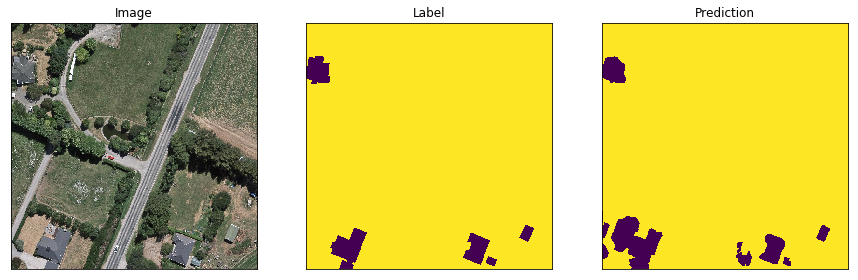

In [21]:
import numpy as np
import paddle
from PIL import Image
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.core import infer
import matplotlib.pyplot as plt

# ModelPath='output/model_kp0.9085/model.pdparams'
# ModelPath='output/iter_4000/model.pdparams'

def nn_infer(img_path, lab_path, model_path=ModelPath, show=True):
    # 网络定义
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # 预测结果
    transforms = T.Compose([
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ])
    img, lab = transforms(img_path, lab_path)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
    if show:
        plt.figure(figsize=(15, 45))
        plt.subplot(131);plt.imshow(Image.open(img_path));plt.xticks([]);plt.yticks([]);plt.title('Image')
        plt.subplot(132);plt.imshow(lab.astype('uint8'));plt.xticks([]);plt.yticks([]);plt.title('Label')
        plt.subplot(133);plt.imshow(pred.astype('uint8'));plt.xticks([]);plt.yticks([]);plt.title('Prediction')
        plt.show()
    return pred.astype('uint8')

name = '0198'
img_path = 'DataSet/image//' + name + '.jpg'
lab_path = 'DataSet/label//' + name + '.png'
_ = nn_infer(img_path, lab_path)

七、导出模型
=======
使用paddle.jit.save将模型保存为预测模型

In [24]:
import paddle
from paddle.static import InputSpec
from paddleseg.models import UNetPlusPlus

def output_inf_model(params_path, save_path):
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    para_state_dict = paddle.load(params_path)
    model.set_dict(para_state_dict)
    paddle.jit.save(model, save_path, [InputSpec([None, 3, 512, 512], 'float32')])

params_path = 'output/iter_20000/model.pdparams'
save_path = "output_inf/UnetPP"
output_inf_model(params_path, save_path)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/math_op_patch.py:341: UserWarning: /tmp/tmp_845v55v.py:35
The behavior of expression A + B has been unified with elementwise_add(X, Y, axis=-1) from Paddle 2.0. If your code works well in the older versions but crashes in this version, try to use elementwise_add(X, Y, axis=0) instead of A + B. This transitional warning will be dropped in the future.
  op_type, op_type, EXPRESSION_MAP[method_name]))


八、加载模型
=======
使用paddle.jit.load将模型加载进去，保证导出的预测模型可以正常使用

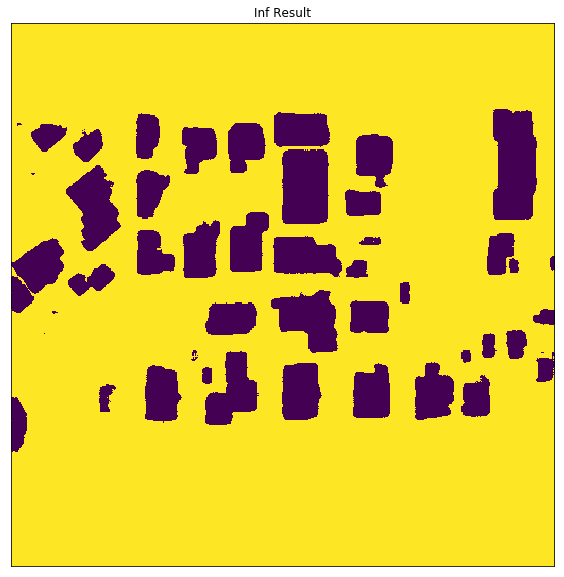

In [25]:
import paddle
import paddleseg.transforms as T
import numpy as np
import matplotlib.pyplot as plt

save_path = "output_inf/UnetPP"
img_path = 'DataSet/image/5255.jpg'
inf_model = paddle.jit.load(save_path)
inf_model.eval()
transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()
])
img, _ = transforms(img_path)
img = paddle.to_tensor(img[np.newaxis, :])
pre = inf_model(img)
pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(pred.astype('uint8'));plt.title('Inf Result');plt.xticks([]);plt.yticks([])
plt.show()

九、总结与升华
=======
将各种语义分割经典网络都实现以下，看看哪个效果最好，再做模型融合，只要集成学习做得好，效果一般都会很不错的。因此，如何有效地设计注意模块，捕捉更多的语义推理特征是未来研究的一个方向。

十、个人总结
=======
曹杨，公司在职人员，ai初学者，兴趣方向是计算机视觉技术中图像处理、人工智能和模式识别等技术。个人主页https://aistudio.baidu.com/aistudio/usercenter

提交链接
=======
aistudio链接：

github链接：

gitee链接：